In [1]:
import os
import sys

sys.path.append("/home/yuri/github.com/AoesJP/project_pokereader")
sys.path

['/home/yuri/.pyenv/versions/3.10.6/lib/python310.zip',
 '/home/yuri/.pyenv/versions/3.10.6/lib/python3.10',
 '/home/yuri/.pyenv/versions/3.10.6/lib/python3.10/lib-dynload',
 '',
 '/home/yuri/.pyenv/versions/3.10.6/envs/project_pokereader/lib/python3.10/site-packages',
 '/home/yuri/github.com/AoesJP/project_pokereader']

In [263]:
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import pyocr
from PIL import Image, ImageEnhance, ImageOps, ImageFilter

import pokedex.utils_dataset as pku
import pokedex.augmentation as pka
from pokedex.edges import deformer, draw

In [5]:
PROJECT_PATH = Path(".").absolute().parent
DATA_PATH = PROJECT_PATH / "data"
DATA_PATH

PosixPath('/home/yuri/github.com/AoesJP/project_pokereader/data')

In [6]:
IMG_PATH = DATA_PATH / "pokemon_card.png"
IMG_PATH.as_posix()

'/home/yuri/github.com/AoesJP/project_pokereader/data/pokemon_card.png'

In [7]:
DATA_JSON_PATH = DATA_PATH / "dict_dataset_full.json"
DATA_JSON_PATH

PosixPath('/home/yuri/github.com/AoesJP/project_pokereader/data/dict_dataset_full.json')

In [8]:
DATA_JSON_LEFT = DATA_PATH / "dict_dataset_full.json"

In [9]:
df_all = pd.read_json(DATA_JSON_PATH)
df_all

,corner,position,set_id,set_name
0,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no
1,"[[190, 190, 190, 190, 190, 190, 190, 190, 190,...",right,dv1,Dragon Vault
2,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no
3,"[[190, 190, 190, 190, 190, 190, 190, 190, 190,...",right,dv1,Dragon Vault
4,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no
...,...,...,...,...
6059,"[[117, 117, 117, 117, 117, 117, 117, 117, 117,...",right,no,no
6060,"[[169, 169, 170, 170, 170, 170, 170, 170, 170,...",left,sv2,Paldea Evolved
6061,"[[117, 117, 117, 117, 117, 117, 117, 117, 117,...",right,no,no
6062,"[[168, 168, 168, 168, 168, 168, 168, 168, 168,...",left,sv2,Paldea Evolved


In [10]:
df_aug = pka.get_augment_data(DATA_JSON_PATH)
df_aug

,corner,position,set_id,set_name
0,"[[[[85], [80], [80], [80], [80], [79], [79], [...",left,no,no
1,"[[[[190], [190], [190], [190], [190], [190], [...",right,dv1,Dragon Vault
2,"[[[[85], [80], [80], [80], [80], [79], [79], [...",left,no,no
3,"[[[[190], [190], [190], [190], [190], [190], [...",right,dv1,Dragon Vault
4,"[[[[85], [80], [80], [80], [80], [79], [79], [...",left,no,no
...,...,...,...,...
9027,"[[[190], [190], [190], [190], [190], [190], [1...",right,dv1,Dragon Vault
9028,"[[[117], [117], [118], [120], [122], [126], [1...",left,no,no
9029,"[[[190], [190], [190], [190], [190], [190], [1...",right,dv1,Dragon Vault
9030,"[[[190], [190], [190], [190], [190], [190], [1...",right,dv1,Dragon Vault


In [11]:
def preproc_clean(data: list):
    _ = np.array(data)
    return np.expand_dims(_, axis=2).astype("uint8")

In [12]:
def preproc_aug(data: list):
    _ = np.array(data)
    return np.squeeze(_.astype("uint8"), axis=0)

In [13]:
def to_rgb(img: np.ndarray):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

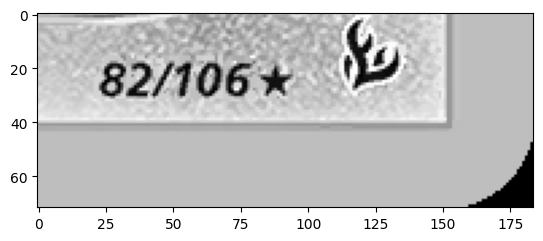

In [16]:
plt.imshow(to_rgb(preproc_aug(df_aug.iloc[1800, 0])))

In [17]:
def ocr_test(img):
    tools = pyocr.get_available_tools()
    tool = tools[0]
    tool
    builder = pyocr.builders.TextBuilder(tesseract_layout=6)
    # builder.tesseract_configs.append("digits")
    builder.tesseract_configs.append("-c")
    builder.tesseract_configs.append("tessedit_char_whitelist=0123456789/")
    builder.tesseract_configs.append("--psm")
    builder.tesseract_configs.append("6")  # 0~13
    builder.tesseract_configs.append("--oem")
    builder.tesseract_configs.append("3")  # 0~3
    res = tool.image_to_string(img, lang="eng", builder=builder)
    # res = tool.image_to_string(img_gray, builder=builder)

    return res

In [80]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-printed")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


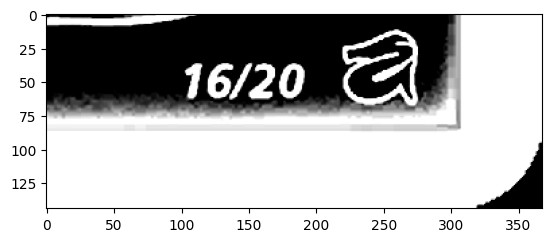

In [262]:
# img = cv2.cvtColor(cv2.imread(IMG_PATH.as_posix()), cv2.COLOR_BGR2RGB)
# plt.imshow(img)
side_offset = 0
# img = to_rgb(preproc_clean(df_all.iloc[643, 0]))
# side_offset = 70
img = to_rgb(preproc_clean(df_all.iloc[30, 0]))
# img = to_rgb(preproc_clean(df_all.iloc[20, 0]))
# img = to_rgb(preproc_clean(df_all.iloc[10, 0]))
# img = to_rgb(preproc_clean(df_all.iloc[40, 0]))
img = Image.fromarray(img)
# img = img.crop((45 + side_offset, 10, 130 + side_offset, 40))
img_contrast = img.resize((img.width * 2, img.height * 2), Image.BICUBIC)
# im2 = img_contrast.filter(ImageFilter.MedianFilter(3))
# im2 = img_contrast.filter(ImageFilter.FIND_EDGES)
# im2 = im2.filter(ImageFilter.MedianFilter(3))
contrast_enhancer = ImageEnhance.Contrast(img_contrast)
img_contrast = contrast_enhancer.enhance(5)
plt.imshow(img_contrast)

In [252]:
median = np.median(img_contrast)
# median = 30
mean = np.mean(img_contrast)
median

255.0

In [253]:
mean

161.48667723429952

In [254]:
# im_offset = np.clip((img_contrast - np.array([mean], dtype="int32")) * 1, 0, 255).astype("uint8")
# plt.imshow(im_offset)

'7'

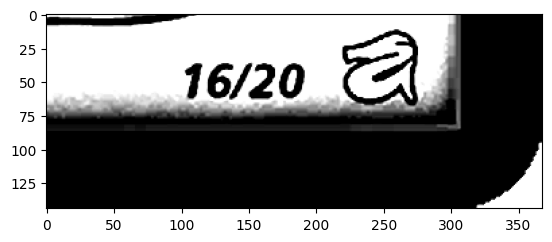

In [255]:
# im_offset = np.clip((img_contrast - np.array([mean], dtype="int32")) * 10, 0, 255).astype("uint8")
# im_offset = np.clip(img_contrast, 0, 255).astype("uint8")
# im_offset = Image.fromarray(im_offset)
# im_offset = Image.fromarray(img_contrast)
# plt.imshow(im_offset, vmin=0, vmax=255)
im_offset = ImageOps.invert(img_contrast)
# im_offset = img_contrast
# im_offset = im_offset.rotate(-6, resample=Image.BICUBIC)
plt.imshow(im_offset)
ocr_test(im_offset)

# pixel_values = processor(images=im_offset, return_tensors="pt").pixel_values

# generated_ids = model.generate(pixel_values)
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
# generated_text